In [2]:
import argparse
from datetime import datetime
import os
import pandas as pd

from utils import seed_everything, get_device, check_max_len, clean_gpu
from utils_config import get_model_config
from trainer import Trainer
from utils import prepare_datasets

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
seed = 1
device = 0
target = 'mirna'
experiment_name = 'jupyter'
verbose=True

In [4]:
kmer=1

In [5]:
max_len = 1024
model_name = "thymba"
batch_size=32

d_model = 64
n_layer = 4
rc = False

is_pretrained = True

pooling_mode_target = 'mean'
is_convblock=False
is_cross_attention=True
rna_model = 'rnaernie'

load_pretrain_name='pt5'

In [6]:
trainer = Trainer(
    seed=seed,
    device=device,
    experiment_name=experiment_name,
    verbose=verbose,
)

INFO:utils:Seeds set to 1.
✅ Logging setup complete.


In [7]:
max_len = check_max_len(max_len, model_name)
# df = pd.read_pickle(f'./data/df_final.pkl')
df = pd.read_pickle(f'./data/df_train_final.pkl')
df_test = pd.read_pickle(f'./data/df_test_final.pkl')

INFO:utils:Max length set to 1022 for model thymba


In [8]:
df['length'] = df['circRNA'].apply(len)
df_test['length'] = df_test['circRNA'].apply(len)
df = df[df['length'] <= max_len]
df_test = df_test[df_test['length'] <= max_len]

In [9]:
df['sum_sites'] = df['sites'].apply(sum)

In [10]:
df[df['sum_sites'] == df['sum_sites'].max()]

,isoform_ID,miRNA_ID,sites,label,circRNA,binding,length,n_binding_site,ratio_binding_site,sum_sites
21760,"chr19|648372,648882,649679,650234,651611,65223...",hsa-miR-4763-3p,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,GAUUAUAUCUGUCCAAGAUGCGAGUCUGGUUUUAUCGAGGAGCUUC...,0,882,349,0.395692,349


In [11]:
train_dataset, valid_dataset, test_dataset, extra_dataset = prepare_datasets(
        df=df, 
        df_test=df_test,
        max_len=max_len + 2,  # 2 for special tokens (CLS and EOS)
        target=target, 
        seed=seed,
        kmer=kmer,
        # df_extra=df_test,
    )

In [12]:
trainer.set_dataloader(train_dataset, part=0, batch_size=batch_size)
trainer.set_dataloader(valid_dataset, part=1, batch_size=batch_size)
trainer.set_dataloader(test_dataset, part=2, batch_size=batch_size)

In [13]:
# Step 4. Configure Model
print('[Step 4] Configuring Model for training')
config = get_model_config(
    model_name=model_name,
    d_model=d_model,
    n_layer=n_layer,
    verbose=verbose,
    rc=rc,
    vocab_size=train_dataset.vocab_size
)

[Step 4] Configuring Model for training
- Model: thymba
- d_model: 64
- n_layer: 4


In [14]:
trainer.define_model(
    config=config,
    model_name=model_name,
    pretrain=is_pretrained,
    pooling_mode_target=pooling_mode_target,
    is_convblock=is_convblock,
    is_cross_attention=is_cross_attention,
)

Model 'thymba' initialized. Pretraining mode: True


In [15]:
trainer.set_pretrained_target(target=target, rna_model=rna_model)

Target model for mirna set with projection dimension 768


Target model for mirna set with projection dimension 768


In [16]:
trainer.model.embedding.word_embeddings.weight

Parameter containing:
tensor([[-0.4857, -0.5479, -1.0810,  ..., -1.4477, -0.4255,  1.7914],
        [ 1.6162,  0.0597,  1.3496,  ...,  0.0131, -1.2506,  0.5650],
        [ 0.0650,  1.6606,  0.3390,  ...,  0.0141,  1.5561,  2.3841],
        ...,
        [-0.5334, -0.5093, -0.8148,  ...,  0.3883,  0.6639, -0.7245],
        [-0.0549, -2.2795,  0.2898,  ...,  0.2876, -0.2124, -1.0975],
        [ 0.3547, -0.7577, -1.0978,  ...,  0.4235, -0.0903, -0.3277]],
       device='cuda:0', requires_grad=True)

In [17]:
trainer.load_model(pretrain=False, load_pretrain_name=load_pretrain_name, verbose=True)

O Model state loaded successfully from ./saved_models/thymba/pt5/1/train/model.pth
X Warning: embedding file not found at ./saved_models/thymba/pt5/1/train/embedding.pth.
X Failed to load embedding from ./saved_models/thymba/pt5/1/train/embedding.pth. Skipping.
X Warning: backbone file not found at ./saved_models/thymba/pt5/1/train/backbone.pth.
X Failed to load backbone from ./saved_models/thymba/pt5/1/train/backbone.pth. Skipping.
X Warning: proj_target file not found at ./saved_models/thymba/pt5/1/train/proj_target.pth.
X Failed to load proj_target from ./saved_models/thymba/pt5/1/train/proj_target.pth. Skipping.
X Warning: convblock file not found at ./saved_models/thymba/pt5/1/train/convblock.pth.
X Failed to load convblock from ./saved_models/thymba/pt5/1/train/convblock.pth. Skipping.
X Warning: binding_head file not found at ./saved_models/thymba/pt5/1/train/binding_head.pth.
X Failed to load binding_head from ./saved_models/thymba/pt5/1/train/binding_head.pth. Skipping.
X Warn

In [18]:
trainer.model.embedding.word_embeddings.weight

Parameter containing:
tensor([[-0.4200, -0.5057, -1.1133,  ..., -1.1586, -0.5641,  1.7780],
        [ 1.7589,  0.0261,  1.3217,  ...,  0.1530, -1.2600,  0.5176],
        [-0.0674,  2.0159,  0.0127,  ..., -0.0899,  1.6889,  2.5117],
        ...,
        [-0.5334, -0.5093, -0.8148,  ...,  0.3883,  0.6639, -0.7245],
        [-0.0549, -2.2795,  0.2898,  ...,  0.2876, -0.2124, -1.0975],
        [ 0.3547, -0.7577, -1.0978,  ...,  0.4235, -0.0903, -0.3277]],
       device='cuda:0', requires_grad=True)

In [19]:
trainer.rc = False
trainer.task = 'both'
trainer.verbose = True

In [20]:
results = trainer.inference(data_loader=trainer.test_loader)

In [55]:
results.pop('lengths_sites')
df_results = pd.DataFrame(results)

In [21]:
results['attn_maps'][0]

tensor([[[0.0407, 0.0398, 0.0398,  ..., 0.0398, 0.0398, 0.0401],
         [0.0407, 0.0398, 0.0398,  ..., 0.0398, 0.0398, 0.0401],
         [0.0408, 0.0398, 0.0398,  ..., 0.0398, 0.0398, 0.0401],
         ...,
         [0.0400, 0.0400, 0.0400,  ..., 0.0400, 0.0400, 0.0400],
         [0.0406, 0.0398, 0.0399,  ..., 0.0398, 0.0398, 0.0401],
         [0.0413, 0.0397, 0.0397,  ..., 0.0396, 0.0397, 0.0401]],

        [[0.0396, 0.0401, 0.0401,  ..., 0.0401, 0.0401, 0.0400],
         [0.0400, 0.0400, 0.0400,  ..., 0.0400, 0.0400, 0.0400],
         [0.0415, 0.0396, 0.0397,  ..., 0.0396, 0.0396, 0.0401],
         ...,
         [0.0397, 0.0401, 0.0401,  ..., 0.0401, 0.0401, 0.0400],
         [0.0398, 0.0401, 0.0401,  ..., 0.0401, 0.0401, 0.0400],
         [0.0398, 0.0401, 0.0401,  ..., 0.0401, 0.0401, 0.0400]],

        [[0.0406, 0.0398, 0.0399,  ..., 0.0398, 0.0398, 0.0401],
         [0.0405, 0.0399, 0.0399,  ..., 0.0399, 0.0399, 0.0400],
         [0.0399, 0.0400, 0.0400,  ..., 0.0400, 0.0400, 0.

In [53]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

def visualize_softmaxed_attention(
    attn_map: torch.Tensor,
    queries_per_row=100,
    figsize_per_row=(10, 2),
    title="Attention Map"
):
    """
    attn_map: torch.Tensor or np.ndarray of shape (L, K)
              (query × key) before softmax
    """
    if isinstance(attn_map, np.ndarray):
        attn_map = torch.tensor(attn_map)

    # Step 1: Apply softmax over keys (dim=1)
    attn_softmax = torch.softmax(attn_map, dim=1)  # (L, K)

    # Step 2: Transpose for visualization (K, L)
    attn = attn_softmax.T.detach().cpu().numpy()
    K, L = attn.shape
    num_splits = math.ceil(L / queries_per_row)

    # Step 3: Plot in multiple rows
    fig, axs = plt.subplots(num_splits, 1, figsize=(figsize_per_row[0], figsize_per_row[1]*num_splits))
    if num_splits == 1:
        axs = [axs]

    for i in range(num_splits):
        start = i * queries_per_row
        end = min((i+1) * queries_per_row, L)
        sns.heatmap(
            attn[:, start:end],
            ax=axs[i],
            cmap='viridis',
            cbar=True,
            xticklabels=10,
            yticklabels=range(K)
        )
        axs[i].set_xlabel(f"Query Positions {start}–{end-1}")
        axs[i].set_ylabel("Key Position")
        axs[i].set_title(f"{title} (queries {start}–{end-1})")

    plt.tight_layout()
    plt.show()


In [42]:
len(results['attn_maps'][0])

17708

In [43]:
len(results['lengths'][0])

17708

In [58]:
df_results.columns

Index(['binding', 'sites', 'lengths', 'attn_maps'], dtype='object')

In [60]:
df_results.head()

,binding,sites,lengths,attn_maps
0,"[[tensor(-2.7056), tensor(1.6308)], [tensor(-6...","[[[tensor(-0.0282), tensor(-0.0908)], [tensor(...","[[tensor(238.)], [tensor(770.)], [tensor(879.)...","[[[tensor(0.0407), tensor(0.0398), tensor(0.03..."


In [59]:
df_results[df_results['lengths'] == 200]

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

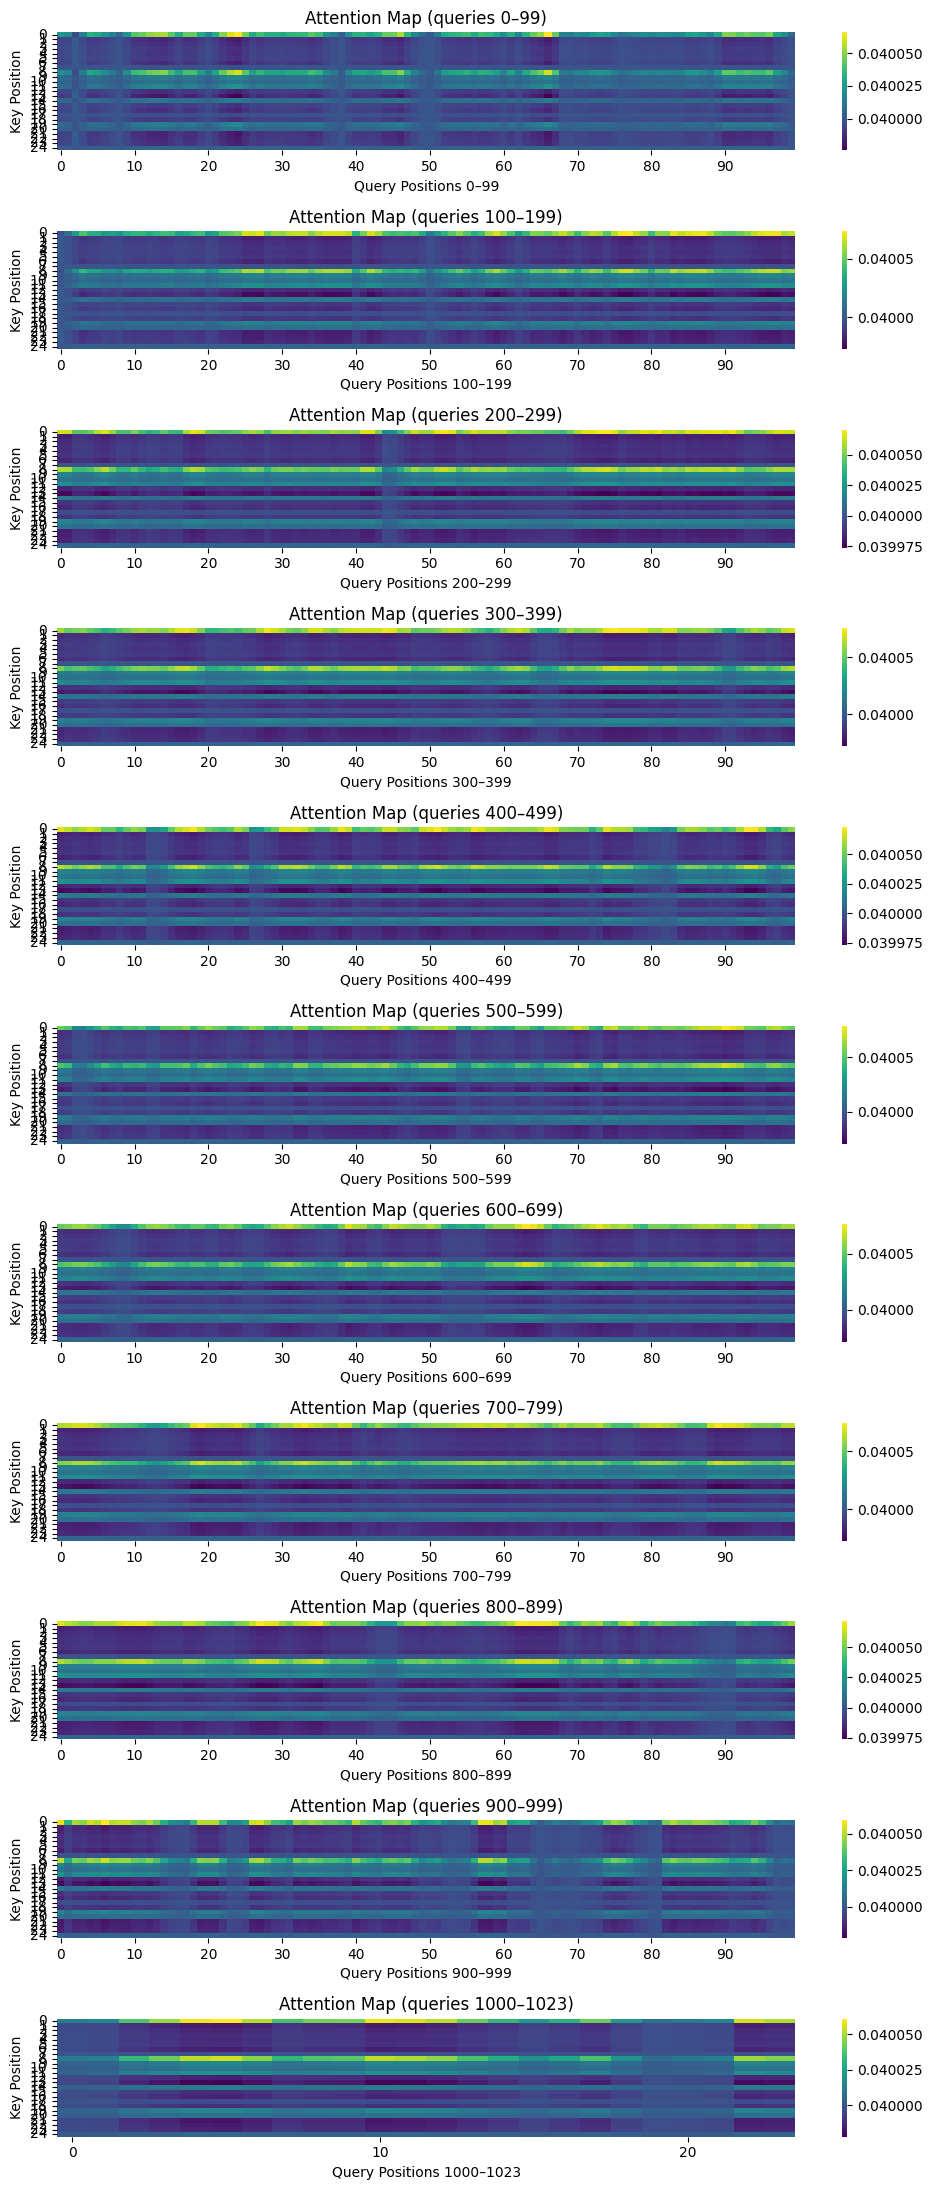

In [54]:
visualize_softmaxed_attention(results['attn_maps'][0][2])

In [21]:
results.pop('lengths_sites')
df_results = pd.DataFrame(results)

In [22]:
import torch
import pandas as pd

def flatten_result_dict_per_sample(result_dict, sequences=None):
    """
    Converts nested result dict to a per-sample DataFrame.
    
    Parameters:
        result_dict: dict with keys ['binding', 'sites', 'lengths']
        sequences: optional list of circRNA sequence strings
    """
    # Unpack
    binding_logits = result_dict['binding'][0]     # list of [2] tensors
    site_logits = result_dict['sites'][0]          # list of [L, 2] tensors
    lengths = result_dict['lengths'][0]            # list of [1] tensors

    data = []
    for i in range(len(binding_logits)):
        sample = {
            "sample_id": i,
            "binding_logits": binding_logits[i].detach().cpu().tolist(),
            "site_logits": site_logits[i].detach().cpu().tolist(),
            "length": int(lengths[i].item())
        }
        if sequences is not None:
            sample["circRNA"] = sequences[i]
        data.append(sample)

    return pd.DataFrame(data)


In [23]:
df_samples = flatten_result_dict_per_sample(results, sequences=df_test['circRNA'].values)


In [24]:
df_results = pd.merge(df_samples, df_test, on='circRNA', how='outer')

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F


def plot_site_prediction_from_df(df, sample_idx):
    row = df.iloc[sample_idx]

    # --- 1. site logits 처리 ---
    logits = torch.tensor(row["site_logits"])
    if logits.dim() == 3:
        logits = logits.squeeze(0)
    if logits.dim() == 1:
        # 예외적으로 [L] 형태라면 → [L, 1]로 reshape
        logits = logits.unsqueeze(-1)
    if logits.size(-1) == 1:
        probs = torch.sigmoid(logits).squeeze(-1).cpu().numpy()
    elif logits.size(-1) == 2:
        probs = F.softmax(logits, dim=-1)[:, 1].cpu().numpy()
    else:
        raise ValueError(f"Unexpected logits shape: {logits.shape}")

    # --- 2. label 처리 ---
    labels = row["label"]
    if isinstance(labels, list) and isinstance(labels[0], list):
        labels = labels[0]
    labels = np.array(labels)
    sites = row['sites']

    # --- 3. 길이 mismatch 방지 ---
    try:
        min_len = min(len(probs), len(sites))
    except TypeError:
        raise ValueError(f"Length error: probs={probs}, labels={sites}")

    probs = probs[:min_len]
    sites = sites[:min_len]

    # --- 4. Plot ---
    plt.figure(figsize=(14, 4))
    plt.plot(probs, label="Predicted binding prob.", color='blue', linewidth=2)
    plt.bar(np.arange(min_len), sites, alpha=0.3, label="True label", color='orange')

    plt.title(f"[Sample {row['sample_id']}] circRNA: {row['circRNA'][:20]}... | miRNA: {row['miRNA_ID']}")
    plt.xlabel("Sequence position")
    plt.ylabel("Binding probability")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


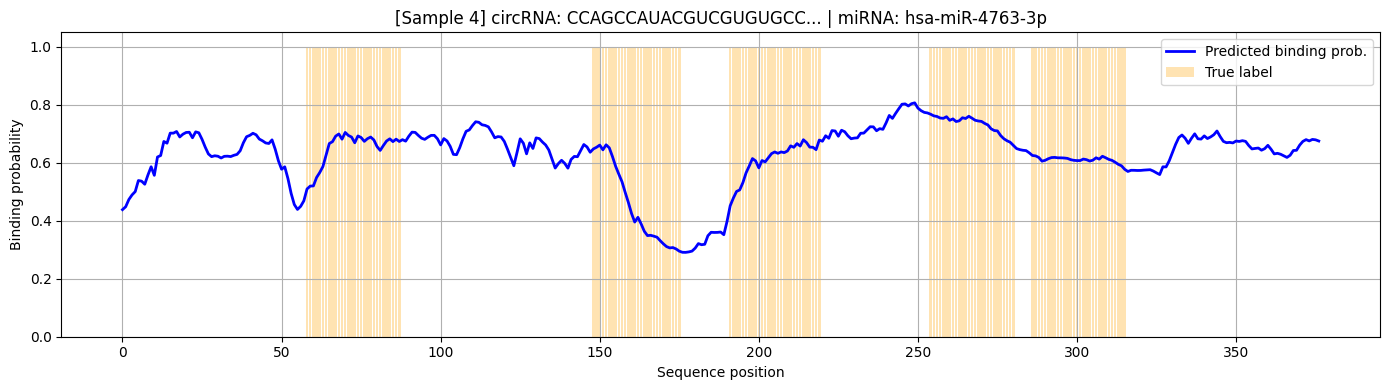

In [26]:
plot_site_prediction_from_df(df_results, sample_idx=10)

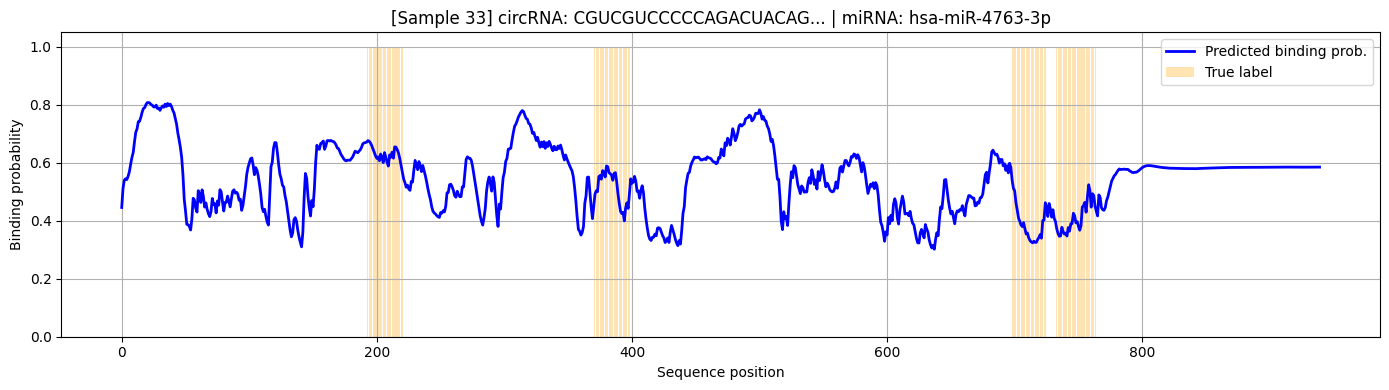

In [27]:
plot_site_prediction_from_df(df_results, sample_idx=12)

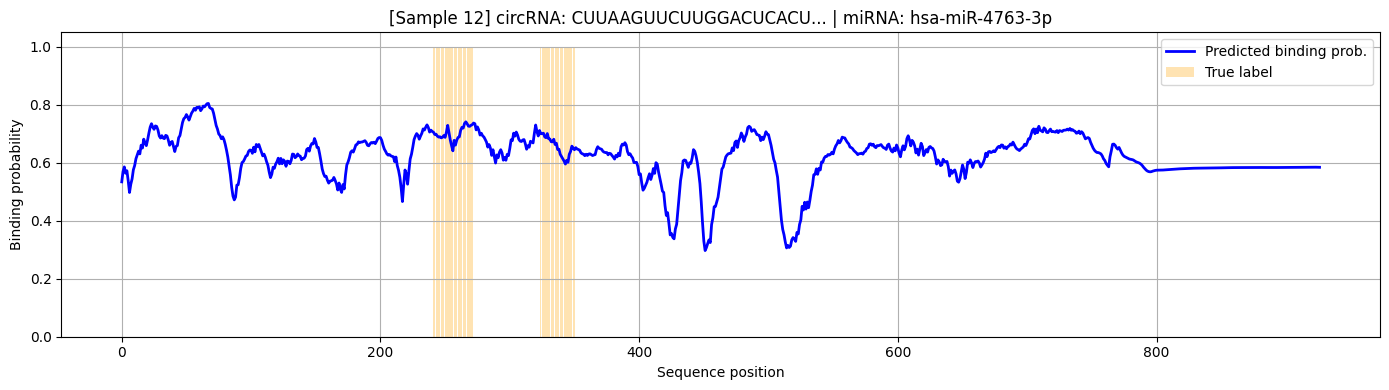

In [28]:
plot_site_prediction_from_df(df_results, sample_idx=15)

In [29]:
def plot_site_prediction_combined(df, sample_idx, threshold=0.5, min_span_len=20):
    import numpy as np
    import matplotlib.pyplot as plt
    import torch
    import torch.nn.functional as F

    def extract_positive_spans(binary_preds, min_len=1):
        spans = []
        start = None
        for i, val in enumerate(binary_preds):
            if val == 1 and start is None:
                start = i
            elif val == 0 and start is not None:
                if i - start >= min_len:
                    spans.append((start, i))
                start = None
        if start is not None and (len(binary_preds) - start) >= min_len:
            spans.append((start, len(binary_preds)))
        return spans

    row = df.iloc[sample_idx]

    # --- 1. Logits → probs ---
    logits = torch.tensor(row["site_logits"])
    if logits.dim() == 3:
        logits = logits.squeeze(0)
    elif logits.dim() == 1:
        logits = logits.unsqueeze(-1)

    if logits.size(-1) == 1:
        probs = torch.sigmoid(logits).squeeze(-1).cpu().numpy()
    elif logits.size(-1) == 2:
        probs = F.softmax(logits, dim=-1)[:, 1].cpu().numpy()
    else:
        raise ValueError(f"Unexpected logits shape: {logits.shape}")

    # --- 2. Label (sites) ---
    sites = row["sites"]
    if isinstance(sites, list) and isinstance(sites[0], list):
        sites = sites[0]
    sites = np.array(sites)

    # --- 3. Sequence 정리 ---
    min_len = min(len(probs), len(sites))
    probs = probs[:min_len]
    sites = sites[:min_len]

    preds_binary = (probs >= threshold).astype(int)
    spans = extract_positive_spans(preds_binary, min_len=min_span_len)

    # --- 4. 마스킹된 예측 확률 (bar) 생성 ---
    masked_probs = np.zeros_like(probs)
    for start, end in spans:
        masked_probs[start:end] = probs[start:end]

    # --- 5. Plotting ---
    plt.figure(figsize=(14, 4))

    # (1) 전체 확률: 라인
    #plt.plot(probs, label="Predicted probability", color='dodgerblue', linewidth=1.5)

    # (2) positive span만 bar
    plt.bar(np.arange(min_len), masked_probs, label="Positive spans", 
            color='skyblue', alpha=0.6)

    # (3) true label도 bar
    plt.bar(np.arange(min_len), sites * probs.max(), label="True binding site", 
            color='orange', alpha=0.4)

    # threshold 선
    #plt.axhline(y=threshold, linestyle='--', color='red', label=f"Threshold = {threshold}")

    # Metadata
    plt.title(f"[Sample {row['sample_id']}] circRNA: {row['circRNA'][:20]}... | miRNA: {row['miRNA_ID']}")
    plt.xlabel("Sequence position")
    plt.ylabel("Binding probability")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


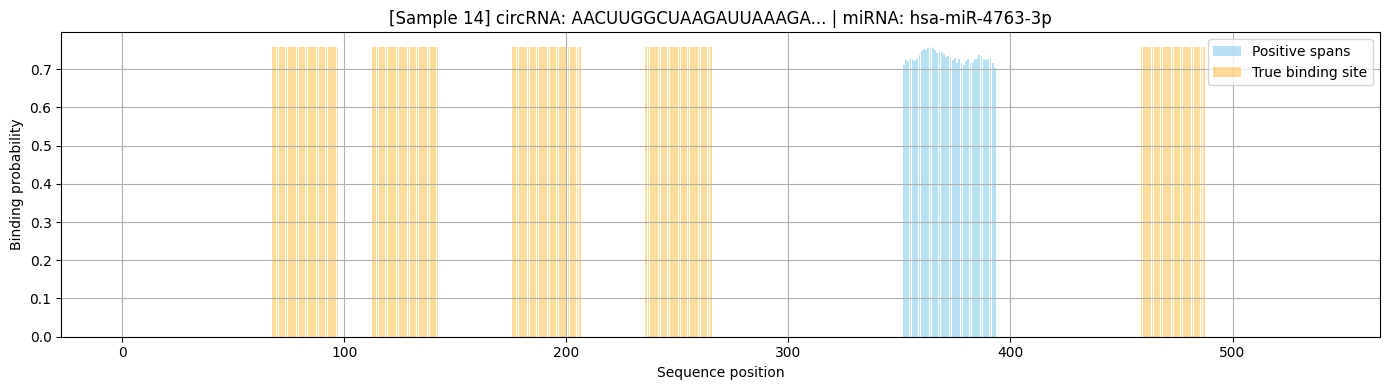

In [30]:
plot_site_prediction_combined(df_results, sample_idx=1, threshold=0.7, min_span_len=22)

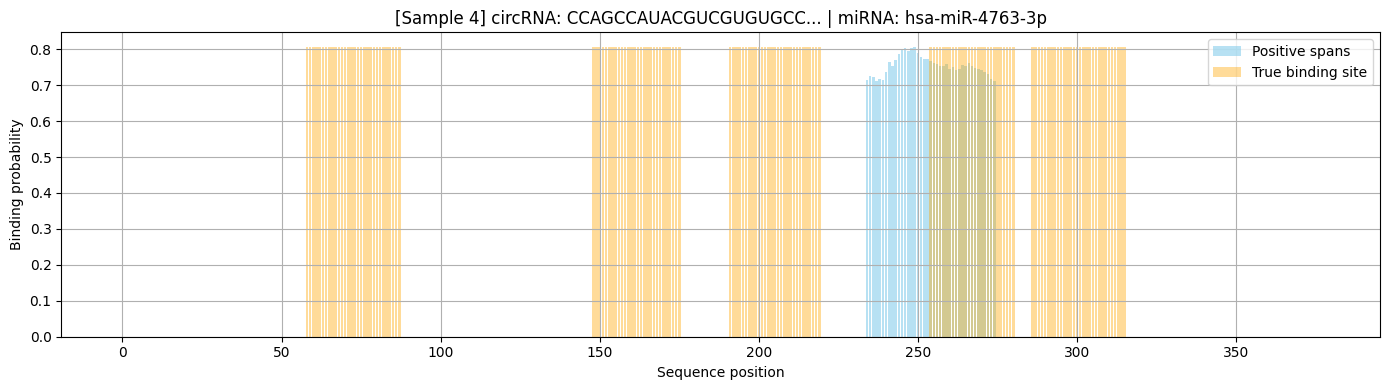

In [31]:
plot_site_prediction_combined(df_results, sample_idx=10, threshold=0.71, min_span_len=22)

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

def extract_positive_spans(binary_preds, min_len=1):
    spans = []
    start = None
    for i, val in enumerate(binary_preds):
        if val == 1 and start is None:
            start = i
        elif val == 0 and start is not None:
            if i - start >= min_len:
                spans.append((start, i))
            start = None
    if start is not None and (len(binary_preds) - start) >= min_len:
        spans.append((start, len(binary_preds)))
    return spans

def linear_binding_site_plot(df, sample_idx=0, threshold=0.5, min_span_len=20):
    row = df.iloc[sample_idx]

    # --- logits → probs ---
    logits = torch.tensor(row["site_logits"])
    if logits.dim() == 3:
        logits = logits.squeeze(0)
    elif logits.dim() == 1:
        logits = logits.unsqueeze(-1)

    if logits.size(-1) == 1:
        probs = torch.sigmoid(logits).squeeze(-1).cpu().numpy()
    elif logits.size(-1) == 2:
        probs = F.softmax(logits, dim=-1)[:, 1].cpu().numpy()
    else:
        raise ValueError(f"Unexpected logits shape: {logits.shape}")

    # --- labels ---
    sites = row["sites"]
    if isinstance(sites, list) and isinstance(sites[0], list):
        sites = sites[0]
    sites = np.array(sites)

    min_len = min(len(probs), len(sites))
    probs = probs[:min_len]
    sites = sites[:min_len]

    preds_binary = (probs >= threshold).astype(int)
    pred_spans = extract_positive_spans(preds_binary, min_len=min_span_len)
    true_spans = extract_positive_spans(sites, min_len=min_span_len)

    # --- Plot ---
    plt.figure(figsize=(14, 4))
    plt.plot(probs, label="Predicted probability", color='dodgerblue', linewidth=1.5)

    for start, end in pred_spans:
        plt.axvspan(start, end, color='skyblue', alpha=0.4, label="Predicted span" if start == pred_spans[0][0] else "")

    for start, end in true_spans:
        plt.axvspan(start, end, color='orange', alpha=0.3, label="True span" if start == true_spans[0][0] else "")

    plt.title(f"[Sample {row['sample_id']}] circRNA: {row['circRNA'][:20]}... | miRNA: {row['miRNA_ID']}")
    plt.xlabel("Sequence position")
    plt.ylabel("Binding probability")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


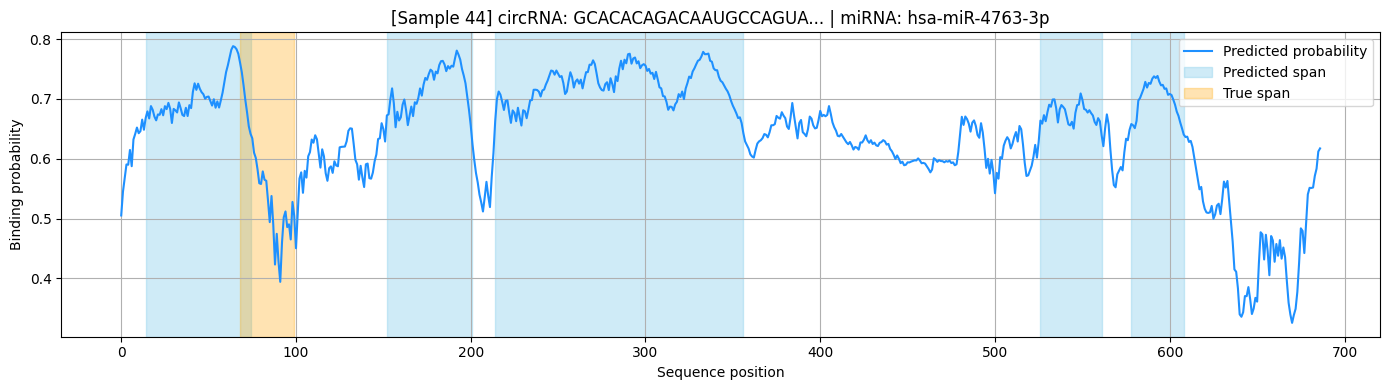

In [33]:
linear_binding_site_plot(df_results, sample_idx=25, threshold=0.65, min_span_len=22)

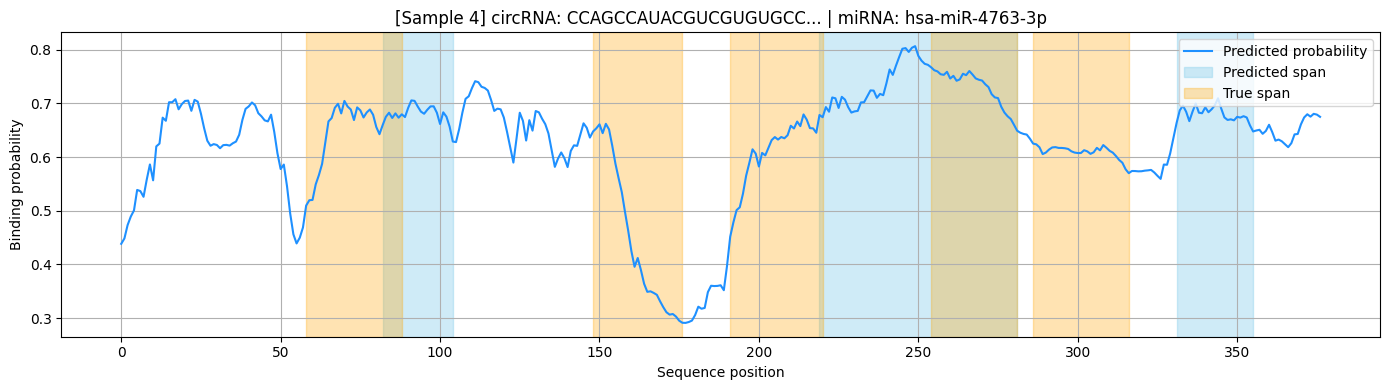

In [34]:
linear_binding_site_plot(df_results, sample_idx=10, threshold=0.65, min_span_len=22)

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

def extract_positive_spans(binary_preds, min_len=1):
    spans = []
    start = None
    for i, val in enumerate(binary_preds):
        if val == 1 and start is None:
            start = i
        elif val == 0 and start is not None:
            if i - start >= min_len:
                spans.append((start, i))
            start = None
    if start is not None and (len(binary_preds) - start) >= min_len:
        spans.append((start, len(binary_preds)))
    return spans

def linear_binding_site_plot(df, sample_idx=0, threshold=0.5, min_span_len=20):
    row = df.iloc[sample_idx]

    # --- logits → probs ---
    logits = torch.tensor(row["site_logits"])
    if logits.dim() == 3:
        logits = logits.squeeze(0)
    elif logits.dim() == 1:
        logits = logits.unsqueeze(-1)

    if logits.size(-1) == 1:
        probs = torch.sigmoid(logits).squeeze(-1).cpu().numpy()
    elif logits.size(-1) == 2:
        probs = F.softmax(logits, dim=-1)[:, 1].cpu().numpy()
    else:
        raise ValueError(f"Unexpected logits shape: {logits.shape}")

    # --- labels ---
    sites = row["sites"]
    if isinstance(sites, list) and isinstance(sites[0], list):
        sites = sites[0]
    sites = np.array(sites)

    min_len = min(len(probs), len(sites))
    probs = probs[:min_len]
    sites = sites[:min_len]

    preds_binary = (probs >= threshold).astype(int)
    pred_spans = extract_positive_spans(preds_binary, min_len=min_span_len)
    true_spans = extract_positive_spans(sites, min_len=min_span_len)

    # --- Plot ---
    plt.figure(figsize=(8, 4))
    plt.plot(probs, label="Predicted probability", color='dodgerblue', linewidth=1.5)

    for start, end in pred_spans:
        plt.axvspan(start, end, color='skyblue', alpha=0.4, label="Predicted span" if start == pred_spans[0][0] else "")

    for start, end in true_spans:
        plt.axvspan(start, end, color='orange', alpha=0.3, label="True span" if start == true_spans[0][0] else "")

    plt.title(f" circRNA: {row['isoform_ID']} | miRNA: {row['miRNA_ID']}")
    plt.xlabel("Sequence position")
    plt.ylabel("Binding probability")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


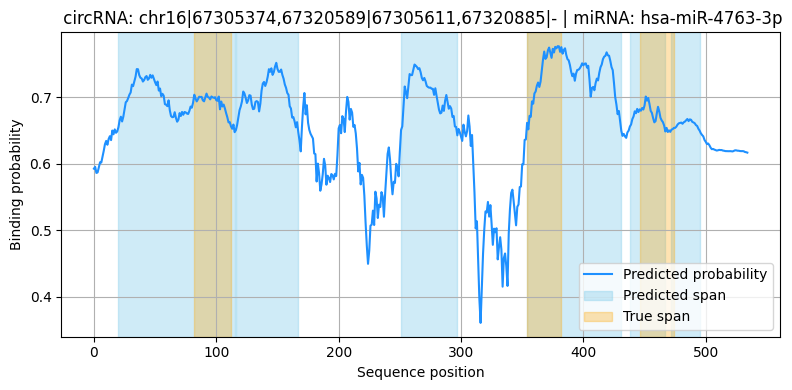

In [36]:
linear_binding_site_plot(df_results, sample_idx=21, threshold=0.65, min_span_len=22)